In [ ]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, measure, color, transform
import napari 
from src.translate_plugin import translate
from matplotlib_venn import venn2
import math
from skimage.measure import regionprops
import seaborn as sns
import matplotlib.patches as patches

Big-FISH version: 0.6.2


In [ ]:
def detect_spots(channel, spot_radius_px, manual_threshold):
    
    # Local maximum detection
    mask = detection.local_maximum_detection(channel, min_distance=spot_radius_px)
    
    # If a manual threshold is provided, use it otherwise, use automated_threshold_setting
    if manual_threshold is not None:
        threshold = manual_threshold
    else:
        threshold = detection.automated_threshold_setting(channel, mask)
    
    # Thresholding
    spots, _ = detection.spots_thresholding(channel, mask, threshold)
    
    return spots.astype(np.uint16), threshold

In [ ]:
# Load f channels and segm mask from cellpose GLU1,2 SUCR1,2 
image = io.imread("E:/FLO8_PP7/FLO8_PP7_1_CY35CY3.tif") # add the image path



In [ ]:
image.shape

(38, 2, 2304, 2304)

In [ ]:
# split the channels and add a segmentation mask if needed
flo8 = image[:,0,:,:]
pp7 = image[:,1,:,:]



In [ ]:
flo8.shape
pp7.shape

(38, 2304, 2304)

In [ ]:
# Observe in focus channels
# viewer = napari.Viewer()
# viewer.add_image(flo8, name='FLO8')
# viewer.add_image(pp7, name='pp7')

<Image layer 'pp7' at 0x25bdd166e30>

In [ ]:
# Define the clean in focus slices range 
start, end = 7, 22 
flo8_focus = flo8[start:end, :, :]
pp7_focus = pp7[start:end, :, :]

In [ ]:
# translate the spot radius  to pixels
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(200, 65, 65),  # in nanometer (one value per dimension; z=microscopy step, (y,x)= microscope voxel size)
    object_radius_nm=(800, 170, 170),  # each spot is 3x3  radius
    ndim=3)
print(spot_radius_px)

(4.0, 2.6153846153846154, 2.6153846153846154)


In [ ]:
# Laplacian of Gaussian filtering of the channels
flo8_log = stack.log_filter(flo8_focus, sigma=spot_radius_px)
pp7_log = stack.log_filter(pp7_focus, sigma=spot_radius_px)

In [ ]:
# viewer = napari.Viewer()
# viewer.add_image(flo8_log, name='FLO8_log')
# viewer.add_image(pp7_log, name='PP7_log')

# Spot detection

In [ ]:
### CHANGE THE DIRECTORY PER EXPeriment, save the spots for further analysis if needed
directory = "E:/FLO8_PP7/spots"
os.makedirs(directory, exist_ok=True)

In [ ]:
# flo8 spot detecttion, uncomment the saving commands if needed
x= 10 #threshold1, add a low threshold number and we are going to filter it out later
spots1, threshold1 = detect_spots(flo8_log, spot_radius_px,x) 
#spots1 = spots1.astype(np.int64)
print("detected flo8 spots")
print("\r shape: {0}".format(spots1.shape))
print("\r threshold: {0}".format(threshold1))
#np.save('spots\exp3_processed_flo8.npy', spots1) #change the name

detected flo8 spots

 shape: (558, 3)

 threshold: 40


In [ ]:
# PP7 spot detecttion, uncomment the saving commands if needed
y= 10 #threshold2,  add a low threshold number and we are going to filter it out later
spots2, threshold2 = detect_spots(pp7_log, spot_radius_px,y)  
#spots1 = spots1.astype(np.int64)
print("detected flo8 spots")
print("\r shape: {0}".format(spots2.shape))
print("\r threshold: {0}".format(threshold2))
#np.save('spots\exp3_processed_pp7.npy', spots2) # change the name

detected flo8 spots

 shape: (630, 3)

 threshold: 45


In [ ]:
# observe the spots
viewer = napari.Viewer()
viewer.add_image(flo8_focus, name='flo8')
viewer.add_image(pp7_focus, name='pp7')
viewer.add_image(pp7_log, name='pp7_log')
viewer.add_image(flo8_log, name='flo8_log')
viewer.add_points(spots1, name='flo8_spots')
viewer.add_points(spots2, name='pp7_spots')

<Points layer 'pp7_spots' at 0x24221a33e50>

# Filter out spots visually through a GUI bar in the NAPARI; creator:Sander van Otterdjik

In [ ]:
# napari has to be open from the previous cell with the spots and layer inside. On the top right side we can filter out spots based on channels (either LoG or raw)
from magicgui import magic_factory, magicgui
from napari.layers import Image, Points

@magicgui(auto_call=False,intensity_threshold={"widget_type": "Slider", 'max': 20000}) #4000 for pp7 and 2180 for flo8
def filter_spots(points: Points, intensity_image : Image, intensity_threshold: int,viewer: napari.Viewer):
    """filter all the spots based on RF class probability and intensity"""
    #extract spots from layer
    spots = points.data 
    
    #filter spots
    filtered_spots = []
    for spot in spots:
        z,y,x = spot
        intensity = intensity_image.data[z,y,x]
    
        if float(intensity) > float(intensity_threshold) :  # filter spots based on intensity
            
            filtered_spots.append([z,y,x])
        
    filtered_spots_array = np.array(filtered_spots)
    
    np.save('filtered_spots.npy', filtered_spots_array) #save spots for further use, add a preferred path, name
    
    
    
    #add new points to viewer 
    viewer.add_points(filtered_spots, name='filtered_spots') 
    
      
viewer.window.add_dock_widget(filter_spots)

# rename the spots after saving them each time

In [ ]:
# add the renamed filtered spots
filtered_flo8_dir = os.path.join(directory, 'filtered_spotsflo8.npy')
filtered_pp7_dir = os.path.join(directory, 'filtered_spotspp7.npy')

spots1 = np.load(filtered_flo8_dir)
spots2 =  np.load(filtered_pp7_dir)



In [ ]:
print("pp7:", len(spots2), "flo8", len(spots1))


pp7: 108 flo8 160


#  Colocalisation Analysis

In [ ]:
# This function is used for the calculation of the overlaping percentage
def calculate_iou(spots__1, spots__2, colocalized):

    # Calculate intersection and union
    intersection = colocalized.shape[0]
    union = spots__1.shape[0] + spots__2.shape[0]

    # Calculate IoU
    #iou = intersection / union if union != 0 else 0.0
    iou = intersection / min(len(spots__1), len(spots__2))
    #max_iou = intersection / max(len(spots__1), len(spots__2))

    return iou 

In [ ]:
# Call the colocalization function from fish package
(spots_1_colocalized, spots_2_colocalized,
 distances, 
 indices_1, indices_2, 
 threshold) = multistack.detect_spots_colocalization(
    spots_1=spots1.astype(np.int64), 
    spots_2=spots2.astype(np.int64),
    threshold = 100, # give a threshold for x,y,z colocalization or add None for automatic calculation (normally it is not accurate)
    voxel_size=(200, 65, 65),
    return_indices=True,
    return_threshold=True)
print("colocalized spots")
print("\r shape 1: {0}".format(spots_1_colocalized.shape))
print("\r shape 2: {0}".format(spots_1_colocalized.shape))
print("\r distances: {0}".format(distances.shape))
print("\r indices 1: {0}".format(spots1.shape))
print("\r indices 2: {0}".format(spots2.shape))
print("\r threshold: {0:0.2f} nm".format(threshold))
#viewer.add_points(spots_1_colocalized)
#viewer.add_points(spots_2_colocalized)

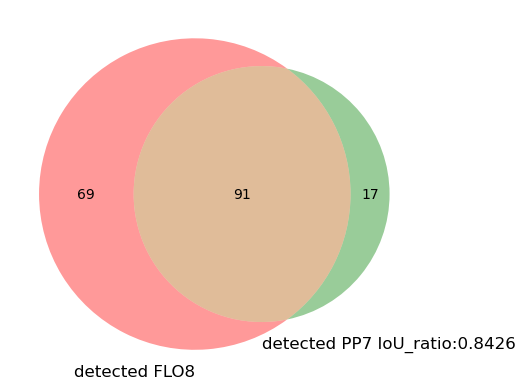

In [ ]:
# Example data (replace these with your actual data)
set1_size = spots1.shape[0]
set2_size = spots2.shape[0]
colocalized_size = spots_1_colocalized.shape[0]
set1_size -= colocalized_size
set2_size -= colocalized_size
iou = calculate_iou(spots1, spots2, spots_2_colocalized)
# Create a Venn diagram
venn_labels = {'100': set1_size, '010': set2_size, '110': colocalized_size}

venn2(subsets=(set1_size, set2_size, colocalized_size), set_labels=('detected FLO8', f'detected PP7 IoU_ratio:{iou:.4f}'))

plt.show()

# Cell counts - Single cell expression

In [ ]:
#insert the mask if we want to use segmentation
segmentation = io.imread('G:/segmentationmask.tif')

#In case the mask has a drift (e.g. if it is based on DIC in the olympus micrscpe) we can translate it with the plugin in src file (github)

# from src.translate_plugin import translate
# viewer = napari.Viewer()
# viewer.window.add_dock_widget(translate())
# viewer.add_image(flo8, name='FLO8')

In [ ]:
#translated_segm =  # add your segmented IDs of your cells
# Labeling and Individual Cell Analysis

labeled_cells = segmentation 

# Regions (cells) are labeled with unique integer values, so with this method we extract cell properties(label, centroid etc.)
cell_props = regionprops(labeled_cells) 

NameError: name 'translated_segm' is not defined

In [ ]:
# extracting cell IDs and counts flo8 or the gene in spots1
flo8_counts = {}

for spot in spots1:
    cell_id = labeled_cells[spot[1], spot[2]] #x, y positions of the spot  for a 2d cell mask from cellpose
    flo8_counts[cell_id] = flo8_counts.get(cell_id, 0) + 1

# Get the maximum cell ID from cell_props
max_cell_id = max([cell.label for cell in cell_props])

# Fill in counts for cells with no spots
for cell_id in range(1, max_cell_id + 1):
    if cell_id not in flo8_counts:
        flo8_counts[cell_id] = 0

# Sort the dictionary based on cell IDs
flo8_counts = dict(sorted(flo8_counts.items()))
# Exclude id = 0 because its the bg
flo8_counts = {k: v for k, v in flo8_counts.items() if k != 0}

flo8_counts = dict(sorted(flo8_counts.items()))
print(flo8_counts)

In [ ]:
# extracting cell IDs and counts pp7 or the gene in spots2
pp7_counts = {}
for spot in spots2:
    cell_id = labeled_cells[spot[1], spot[2]]
    pp7_counts[cell_id] = pp7_counts.get(cell_id, 0) + 1

# Get the maximum cell ID from cell_props
max_cell_id = max([cell.label for cell in cell_props])

# Fill in counts for cells with no spots
for cell_id in range(1, max_cell_id + 1):
    if cell_id not in pp7_counts:
        pp7_counts[cell_id] = 0

#Exclude id = 0, its the bg
pp7_counts = {k: v for k, v in pp7_counts.items() if k != 0}

pp7_counts = dict(sorted(pp7_counts.items()))
print(pp7_counts)

#  Plot genes percentages across cells

In [ ]:
# Count the occurrences of each value for both dictionaries
value_counts1 = {}
for count in flo11_counts.values():
    value_counts1[count] = value_counts1.get(count, 0) + 1

value_counts2 = {}
for count in flo8_counts.values():
    value_counts2[count] = value_counts2.get(count, 0) + 1

# Calculate percentages based on the total number of counts for both dictionaries
total_counts1 = sum(value_counts1.values())
percentages1 = [count / total_counts1 * 100 for count in value_counts1.values()]

total_counts2 = sum(value_counts2.values())
percentages2 = [count / total_counts2 * 100 for count in value_counts2.values()]

# histograms
plt.bar(list(value_counts1.keys()), percentages1, color='blue', alpha=0.7, width=0.4, align='center', label='FLO11')
plt.bar(list(value_counts2.keys()), percentages2, color='orange', alpha=0.7, width=0.4, align='edge', label='FLO8')

# Set labels and title
plt.xlabel('Count of Cells')
plt.ylabel('Percentage of Cells')
plt.title('Glucose 2% mRNA counts')
total_cells_annotation = f'Total Cells: {total_counts1}'
plt.annotate(total_cells_annotation, xy=(0.9, 0.80), xycoords='axes fraction', ha='center', fontsize=10, color='black')

# enter the larger value counts for the plot numbers
plt.xticks(list(value_counts2.keys()))
# Rotate x-axis labels
plt.xticks(rotation=45, ha='left')

# Set y-axis range from 0 to 100
plt.ylim(0, 100)
plt.legend()

plt.show()